# Comparing Implicit Models on Synthetic Data
> Generating a small synthetic implicit data with Gamma distributed interaction and fitting ALS, BPR, PoissonMF, and HPFRec models

- toc: true
- badges: true
- comments: true
- categories: [Implicit, SyntheticDataset]
- author: "<a href='https://github.com/david-cortes'>David Cortes</a>"
- image:

### Installation

In [ ]:
# !pip install --no-use-pep517 poismf implicit hpfrec

In [ ]:
import numpy as np
import pandas as pd

from scipy.sparse import coo_matrix, csr_matrix, csc_matrix

from poismf import PoisMF
from implicit.als import AlternatingLeastSquares
from implicit.bpr import BayesianPersonalizedRanking
from hpfrec import HPF ### <- Bayesian version

### Synthetic Data Generation

In [ ]:
## Generating random sparse data
nusers = 10 ** 2
nitems = 10 ** 3
nnz    = 10 ** 4

np.random.seed(1)
df = pd.DataFrame({
    'UserId' : np.random.randint(nusers, size = nnz),
    'ItemId' : np.random.randint(nitems, size = nnz),
    'Count'  : 1 + np.random.gamma(1, 1, size = nnz).astype(int)
})

df.head()

,UserId,ItemId,Count
0,37,486,2
1,12,151,1
2,72,122,1
3,9,889,3
4,75,311,1


In [ ]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
UserId,10000.0,49.5362,28.820259,0.0,25.0,50.0,75.00,99.0
ItemId,10000.0,500.8950,288.165823,0.0,248.0,507.5,748.25,999.0
Count,10000.0,1.5737,0.954390,1.0,1.0,1.0,2.00,10.0


### Train/Test Split

In [ ]:
from sklearn.model_selection import train_test_split

df_train, df_test = train_test_split(df, test_size=.2)
df_train = df_train.copy()
users_train = np.unique(df_train.UserId.to_numpy())
items_train = np.unique(df_train.ItemId.to_numpy())
df_test = df_test.loc[df_test.UserId.isin(users_train) &
                      df_test.ItemId.isin(items_train)]
df_train["UserId"] = pd.Categorical(df_train.UserId, users_train).codes
df_train["ItemId"] = pd.Categorical(df_train.ItemId, items_train).codes
df_test["UserId"] = pd.Categorical(df_test.UserId, users_train).codes
df_test["ItemId"] = pd.Categorical(df_test.ItemId, items_train).codes
users_test = np.unique(df_test.UserId.to_numpy())

print("Number of entries in training data: {:,}".format(df_train.shape[0]))
print("Number of entries in test data: {:,}".format(df_test.shape[0]))
print("Number of users in training data: {:,}".format(users_train.shape[0]))
print("Number of users in test data: {:,}".format(users_test.shape[0]))
print("Number of items in training and test data: {:,}".format(items_train.shape[0]))

Number of entries in training data: 8,000
Number of entries in test data: 2,000
Number of users in training data: 100
Number of users in test data: 100
Number of items in training and test data: 1,000


### Util function to print ranking metrics

In [ ]:
from sklearn.metrics import roc_auc_score
from joblib import Parallel, delayed

## Note: this is a computationally inefficient implementation of the
## test metrics, not recommended to use outside of this notebook
def print_ranking_metrics(A, B, df_train, df_test, users_test,
                          nusers=1000, top_n=5, seed=1,
                          njobs=-1):
    """
    Parameters
    ----------
    A : array(m, k)
        The user-factor matrix.
    B : array(n, k)
        The item-factor matrix
    df_train : DataFrame(n_train, [user, item, value])
        The training triplets.
    df_test : DataFrame(n_test, [user, item, value])
        The hold-out triplets.
    n_user : int
        Number of users to sample.
    top_n : int
        Number of top-ranked items to calculate precision.
    seed : int
        Random seed used to select the users.
    njobs : int
        Number of jobs to run in parallel.
    """
    n_users = A.shape[0]
    n_items = B.shape[0]
    rng = np.random.default_rng(seed=seed)
    chosen_users = rng.choice(users_test, size=nusers, replace=False)
    all_train = df_train.loc[df_train.UserId.isin(chosen_users)]
    all_test = df_test.loc[df_test.UserId.isin(chosen_users)]
    
    def metrics_single_user(user):
        ypos = all_test.ItemId.loc[all_test.UserId == user].to_numpy()
        ytrain = all_train.ItemId.loc[all_train.UserId == user].to_numpy()
        yneg = np.setdiff1d(np.arange(n_items), np.r_[ypos, ytrain])
        ytest = np.r_[yneg, ypos]
        yhat = B[ytest].dot(A[user])
        auc = roc_auc_score(np.r_[np.zeros(yneg.shape[0]),
                                  np.ones(ypos.shape[0])],
                            yhat)
        topN = np.argsort(-yhat)[:top_n]
        p_at_k = np.mean(topN >= yneg.shape[0])
        p_at_k_rnd = ypos.shape[0] / ytest.shape[0] ## <- baseline
        return auc, p_at_k, p_at_k_rnd

    res_triplets = Parallel(n_jobs = njobs)\
                    (delayed(metrics_single_user)(u) \
                        for u in chosen_users)

    res_triplets = np.array(res_triplets)
    auc = np.mean(res_triplets[:,0])
    p_at_k = np.mean(res_triplets[:,1])
    p_at_k_rnd = np.mean(res_triplets[:,2])
    print("AUC: %.4f [random: %.2f]" % (auc, 0.5))
    print("P@%d: %.4f [random: %.4f]" % (top_n,
                                         p_at_k,
                                         p_at_k_rnd))

### PoisMF

**Poisson factorization**

The model is described in more detail in [Fast Non-Bayesian Poisson Factorization for Implicit-Feedback Recommendations](https://arxiv.org/abs/1811.01908).

The basic idea is to take a sparse input matrix of counts $\mathbf{X}_{m,n}$, which in this case is given by the number of times each user (row in the matrix) played each song (column in the matrix), and find an approximation as the product of two non-negative lower-dimensional latent factor matrices $\mathbf{A}_{m,k}$ and $\mathbf{B}_{n,k}$ by maximizing Poisson likelihood, i.e. fit a model:
$$
\mathbf{X} \sim \text{Poisson}(\mathbf{A} \mathbf{B}^T)
$$

Which is then used to make predictions on the missing (zero-valued) entries, with the highest-predicted items for each user being the best candidates to recommend.

The poisemf package offers different optimization methods which have different advantages in terms of speed and quality, and depending on the settings, is usually able to find good solutions in which the latent factors matrices $\mathbf{A}$ and $\mathbf{B}$ are sparse (i.e. most entries are exactly zero).
** *

In [ ]:
model = PoisMF(k=5, method="pg")
model.fit(df_train)

print_ranking_metrics(model.A, model.B,
                      df_train, df_test, users_test,
                      nusers=20)

AUC: 0.4931 [random: 0.50]
P@5: 0.0300 [random: 0.0218]


In [ ]:
model = PoisMF(k=5, method="tncg")
model.fit(df_train)

print_ranking_metrics(model.A, model.B,
                      df_train, df_test, users_test,
                      nusers=20)

AUC: 0.4922 [random: 0.50]
P@5: 0.0300 [random: 0.0218]


In [ ]:
model = PoisMF(k=5, method="cg")
model.fit(df_train)

print_ranking_metrics(model.A, model.B,
                      df_train, df_test, users_test,
                      nusers=20)

AUC: 0.5209 [random: 0.50]
P@5: 0.0300 [random: 0.0218]


In [ ]:
model.A[0]

array([0.03287788, 0.03228867, 0.0322229 , 0.03906599, 0.04199555])

### Ranking and Prediction

In [ ]:
model.topN(user = 2, n = 5, exclude = df_train.ItemId.loc[df_train.UserId==2])

array([715, 485, 904, 466, 688])

In [ ]:
model.topN_new(df_train.loc[df_train.UserId==2], n = 5, exclude = df_train.ItemId.loc[df_train.UserId==2])

array([715, 485, 904, 466, 688])

In [ ]:
model.predict(user=[3,3,3], item=[3,4,11])

array([1.23424932e-08, 1.28625460e-03, 6.78770370e-04])

### Sparse Matrix

In [ ]:
## Note: package implicit takes a matrix of shape [items, users]
## Other packages take a matrix of shape [users, items]
Xcoo = coo_matrix((df_train.Count, (df_train.UserId, df_train.ItemId)))
Xcoo_T = Xcoo.T
Xcsr_T = csr_matrix(Xcoo_T)

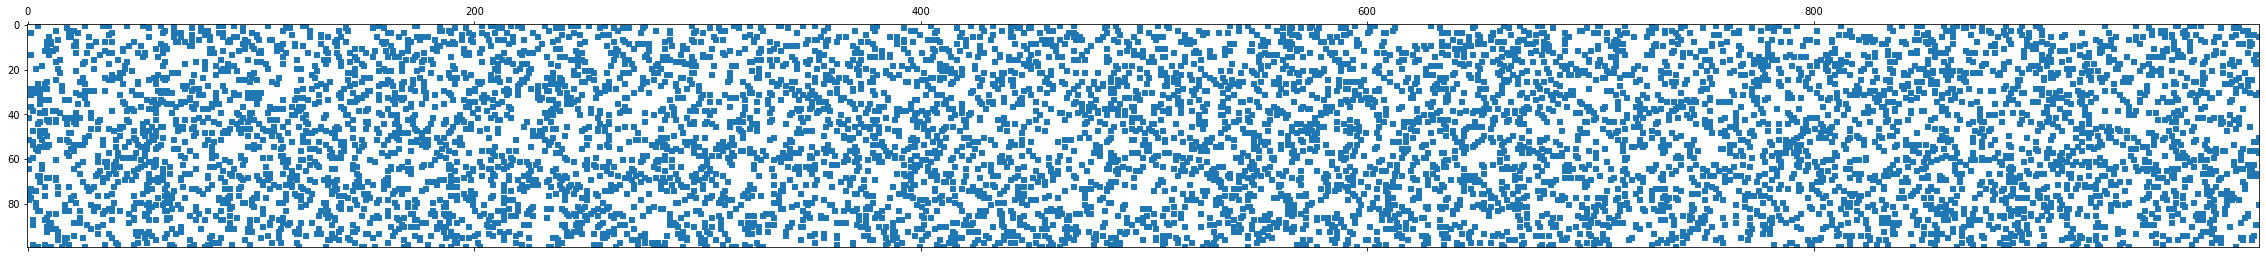

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(40,80))
plt.spy(Xcoo, markersize=5)

### ALS

In [ ]:
ials = AlternatingLeastSquares(factors=5, regularization=0.01,
                               dtype=np.float64, iterations=5,
                               use_gpu=False)
ials.fit(Xcsr_T)

print_ranking_metrics(ials.user_factors, ials.item_factors,
                      df_train, df_test, users_test, nusers=20)


AUC: 0.5336 [random: 0.50]
P@5: 0.0200 [random: 0.0218]


### BPR

In [ ]:
bpr = BayesianPersonalizedRanking(factors=5, regularization=0.01,
                               dtype=np.float64, iterations=5,
                               use_gpu=False)
bpr.fit(Xcsr_T)

print_ranking_metrics(bpr.user_factors, bpr.item_factors,
                      df_train, df_test, users_test, nusers=20)


AUC: 0.5126 [random: 0.50]
P@5: 0.0600 [random: 0.0218]


### HPF

In [ ]:
hpf = HPF(k=5, verbose=False, use_float=False).fit(Xcoo)

print_ranking_metrics(hpf.Theta, hpf.Beta,
                      df_train, df_test, users_test, nusers=20)

AUC: 0.5234 [random: 0.50]
P@5: 0.0200 [random: 0.0218]
